In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Data import Data
from itertools import product
from sklearn.linear_model import LogisticRegression
from SegmentedModel import SegmentedModel
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

In [3]:
data=Data()

## Get a baseline score with logistic regression

In [4]:
data.merge_dataset(exclude_columns=['sub_grade','Volatility'], type='dummy')
X_train, X_test, y_train, y_test = data.get_train_test_set()

model = LogisticRegression()
model.fit(X_train,y_train)
lr_score = model.score(X_test,y_test)
print lr_score

0.852392292704


## Get a baseline score with random forest

In [5]:
data.merge_dataset(exclude_columns=['sub_grade','Volatility'])
X_train, X_test, y_train, y_test = data.get_train_test_set()
model = RandomForestClassifier(n_estimators=400, n_jobs = -1)
model.fit(X_train, y_train)
rf_score = model.score(X_test, y_test)
print rf_score

0.916028000289


## Construct groups for segmentation

In [6]:
df = data.df

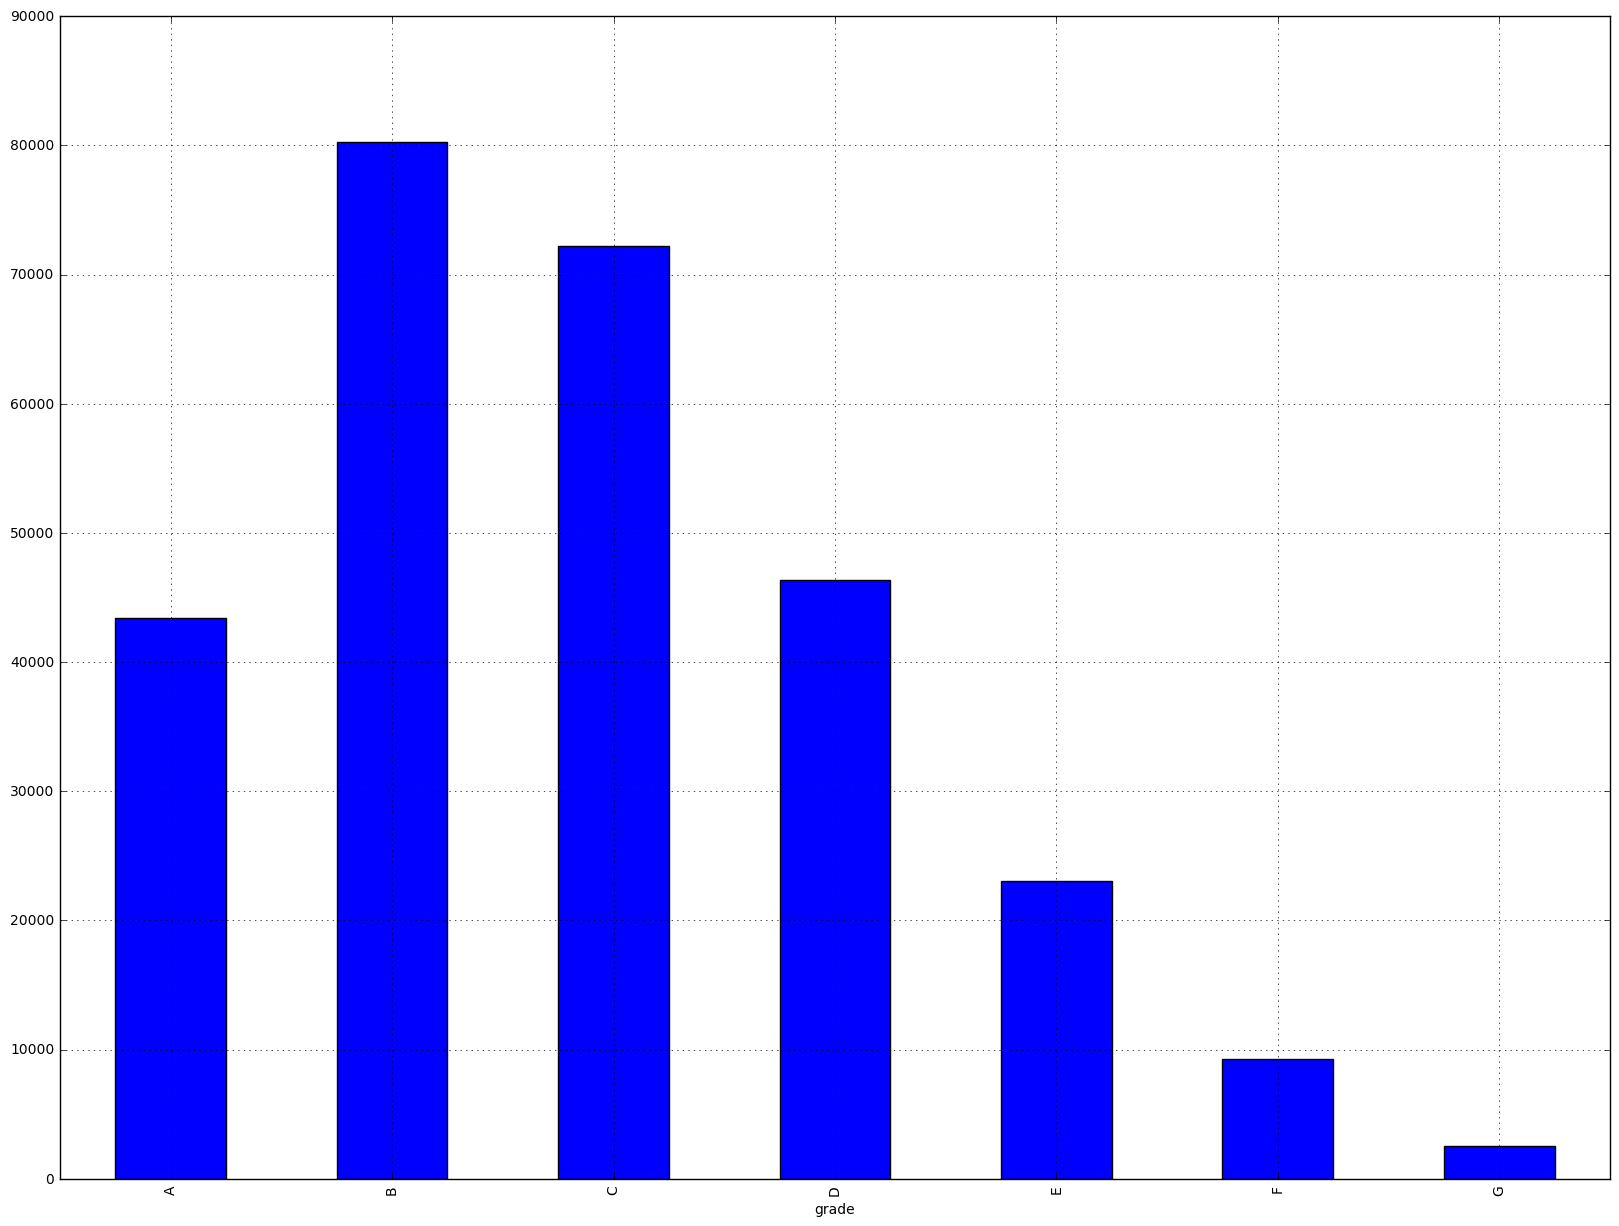

In [7]:
df.groupby('grade').size().plot(kind='bar').grid()

### Merge small groups to have groups of similar size

In [8]:
groups_grade = [('grade' , [['A'], ['B'], ['C'], ['D'], ['E', 'F', 'G']])]

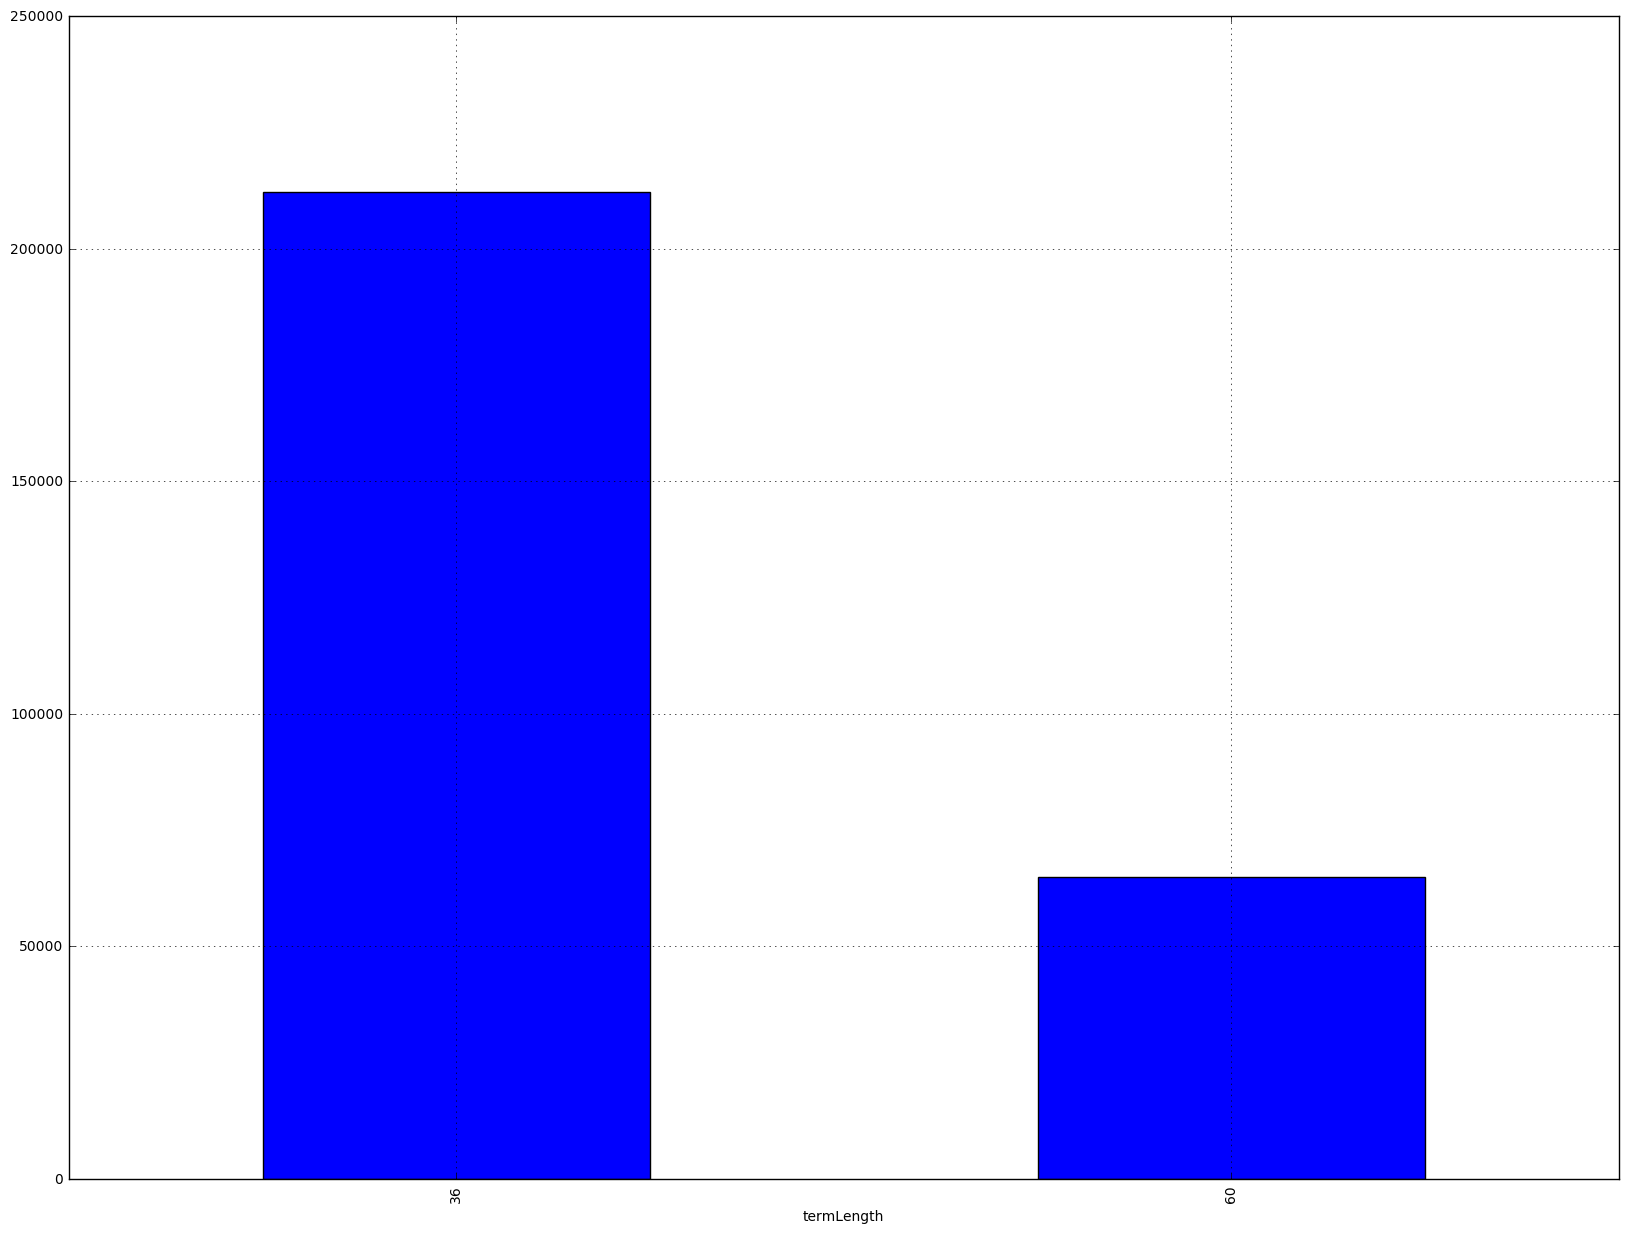

In [9]:
df.groupby('termLength').size().plot(kind='bar').grid()

In [10]:
groups_termLength =[('termLength', [[36], [60]])]

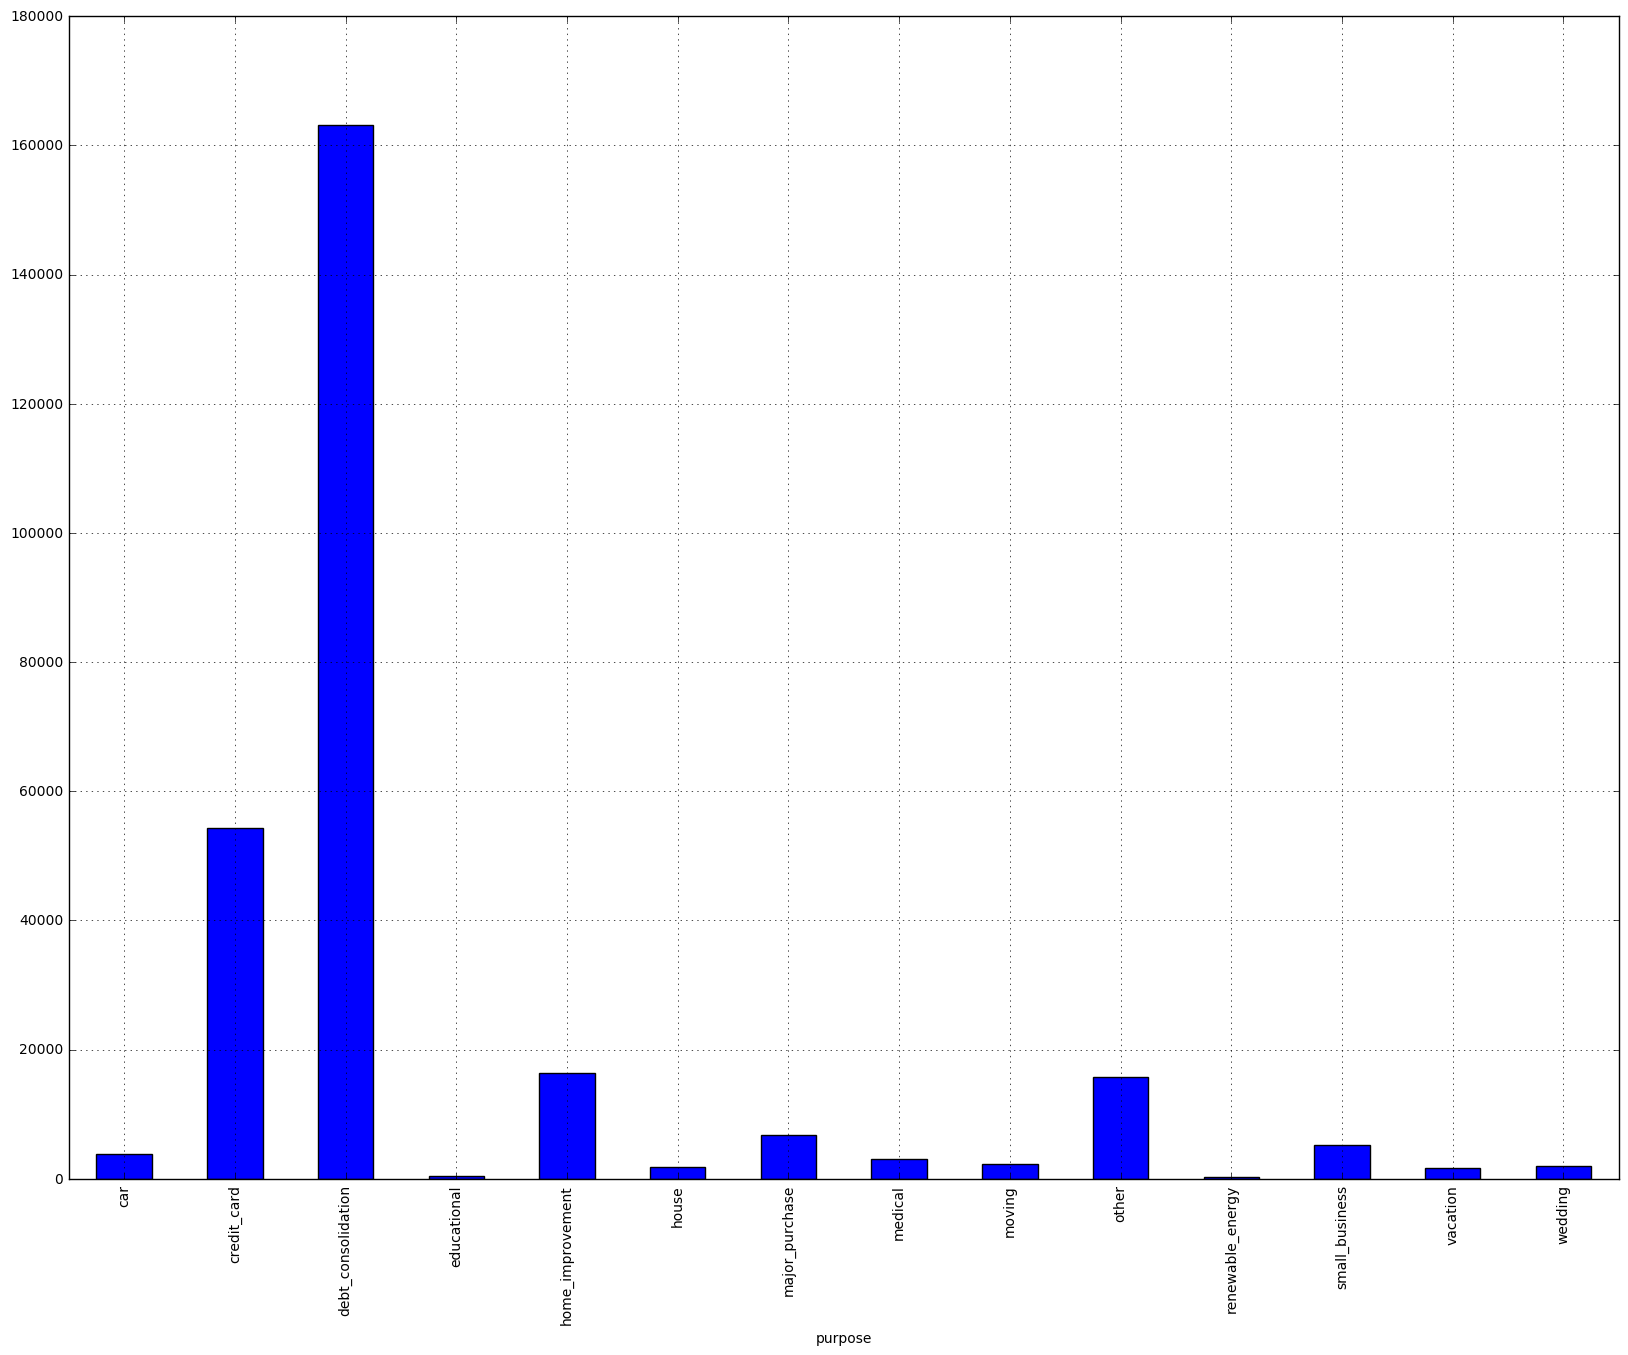

In [11]:
df.groupby('purpose').size().plot(kind='bar').grid()

In [12]:
groups_purpose = [('purpose',[['credit_card'],['debt_consolidation'],
 ['car',
 'small_business',
 'other',
 'wedding',
 'home_improvement',
 'major_purchase',
 'medical',
 'moving',
 'vacation',
 'house',
 'renewable_energy',
 'educational']])]

## Run segmented models with all groups and combinations of them

In [13]:
groups_list=[groups_grade,
             groups_purpose,
             groups_termLength,
             groups_grade+groups_purpose,
             groups_termLength+groups_grade,
             groups_purpose+groups_termLength,
             groups_grade+groups_purpose+groups_termLength]

### The segmented models can be built using the custom SegmentedModel class. The data can be segmented using multiple columns

In [17]:
group_trainscores = []
group_testscores = []
group_names = []
model = LogisticRegression()

for groups in groups_list:
    group_columns = list(zip(*groups)[0])
    group_names.append('\n'.join(group_columns))
    data.merge_dataset(exclude_columns=['sub_grade','Volatility']+group_columns, type='dummy')
    sm = SegmentedModel(df, groups, model)
    sm.fit(data.get_train_test_set())
    group_trainscores.append(sm.trainscore)
    group_testscores.append(sm.testscore)

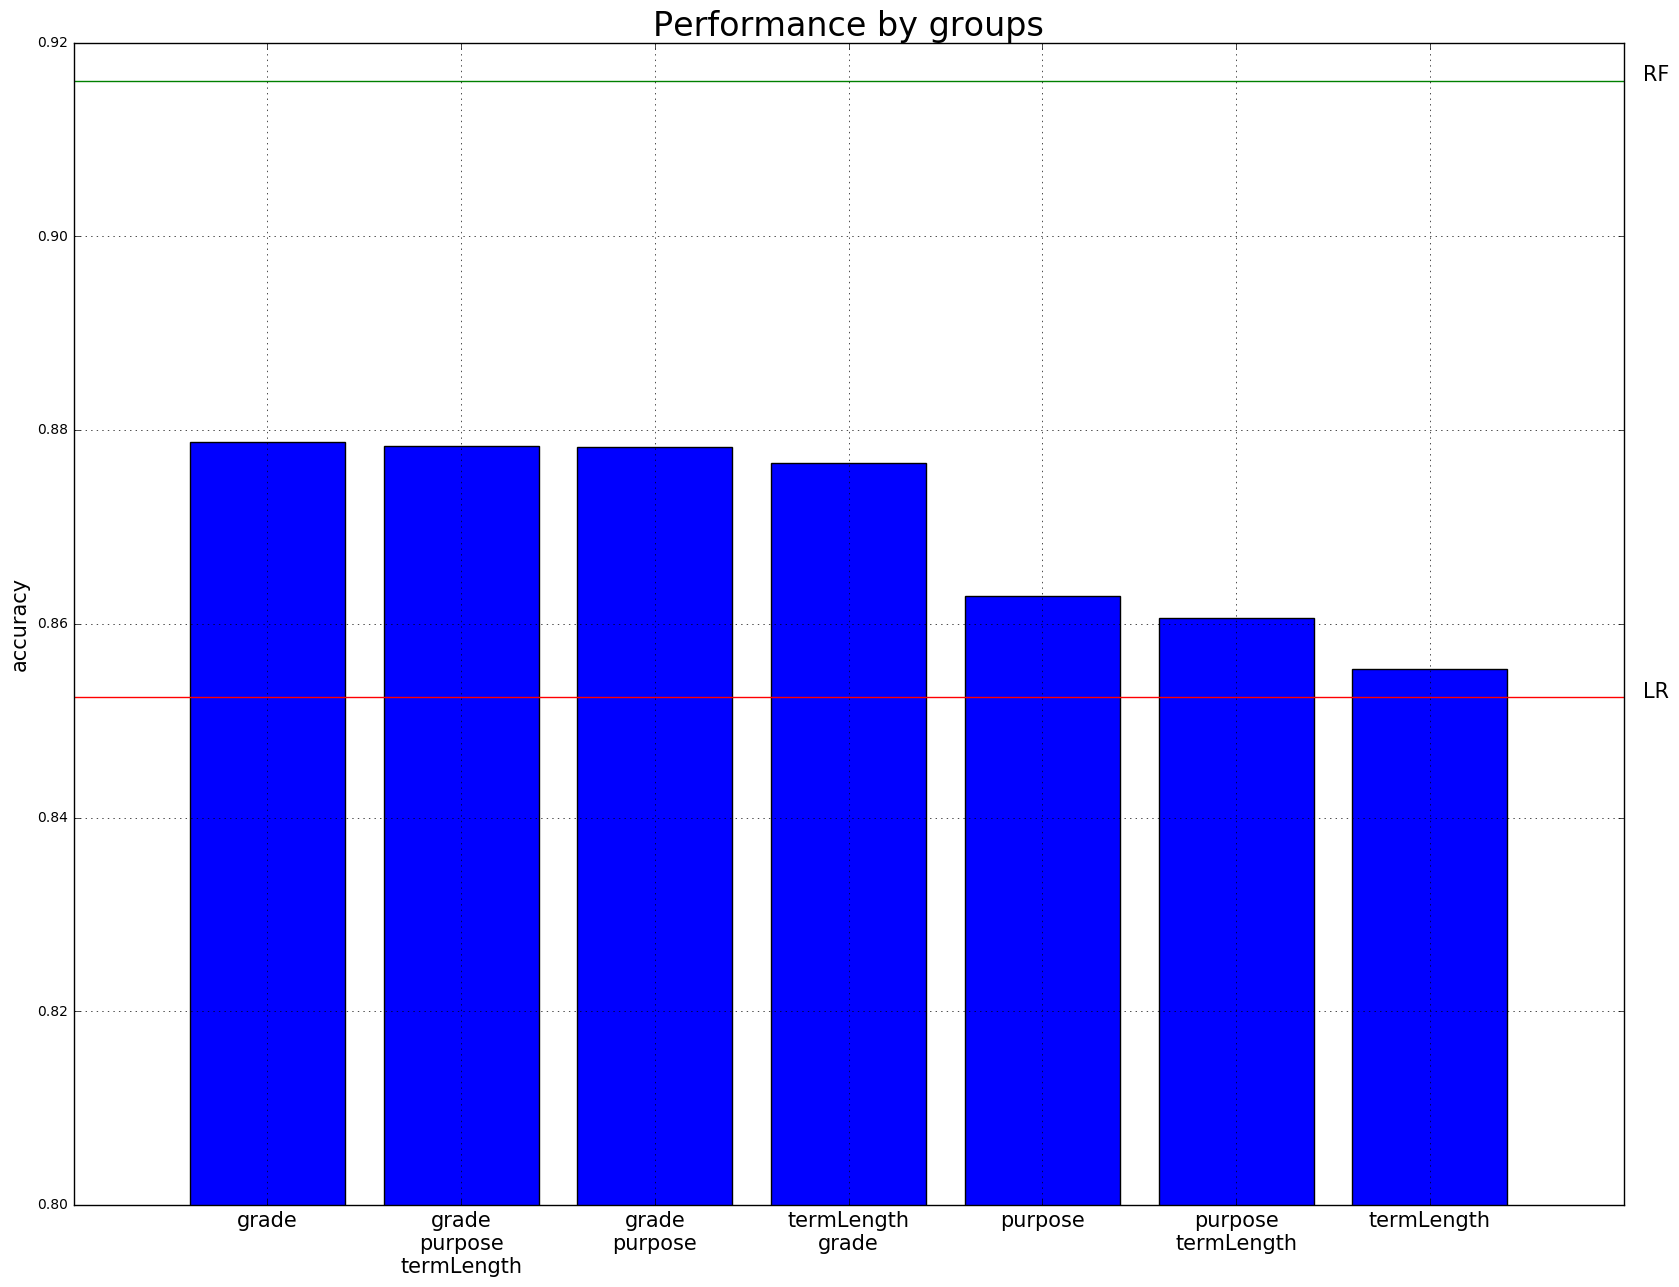

In [18]:
(group_testscores,group_names) = zip(*sorted(zip(group_testscores,group_names),reverse=True))
plt.bar(range(len(group_names)),group_testscores,align='center')
plt.xticks(range(len(group_names)),group_names, fontsize=15)    
plt.ylim((.8,0.92))
plt.grid()
plt.axhline(y=lr_score, color='r', linestyle='-')    
plt.axhline(y=rf_score, color='g', linestyle='-')    
plt.text(7.1,lr_score,'LR', fontsize=15)    
plt.text(7.1,rf_score,'RF', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('Performance by groups', fontsize='24')

In [19]:
print np.array([group_testscores,group_trainscores]).T

[[ 0.87871834  0.87962245]
 [ 0.87831421  0.8629705 ]
 [ 0.87822761  0.85516964]
 [ 0.87658223  0.87988743]
 [ 0.86284188  0.87688293]
 [ 0.86063361  0.85932753]
 [ 0.85530779  0.87944294]]


## Conclusion

### All segmentation options gave better accuracy than the baseline logistic regression model. The best result is achieved by segmenting only on the grade column, which improved the baseline performance by nearly 3%. 